In [148]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.decomposition import PCA
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATASET_FOLDER = "/home/sanjeepshrmaa/AI_PCA_Project/final_images_dataset"  # dataset path
N_COMPONENTS = 50
IMAGE_SIZE = (64, 64)

# Set plot parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported and configuration set")
print(f"Dataset: {DATASET_FOLDER}")
print(f"Components: {N_COMPONENTS}, Image size: {IMAGE_SIZE}")

Libraries imported and configuration set
Dataset: /home/sanjeepshrmaa/AI_PCA_Project/final_images_dataset
Components: 50, Image size: (64, 64)


In [149]:
class PCAImageReconstruction:
    
    def __init__(self, n_components=50, image_size=(64, 64)):
        self.n_components = n_components
        self.image_size = image_size
        self.pca = PCA(n_components=n_components)
        self.original_images = None
        self.flattened_images = None
        
    def load_images(self, folder_path):
    
        print(f"Loading images from: {folder_path}")
        
        # Find image files
        extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
        image_files = []
        for ext in extensions:
            image_files.extend(Path(folder_path).glob(f'*{ext}'))
            image_files.extend(Path(folder_path).glob(f'*{ext.upper()}'))
        
        if not image_files:
            raise ValueError(f"No images found in {folder_path}")
        
        # Load and process images
        images = []
        for img_path in image_files:
            try:
                img = Image.open(img_path).convert('RGB').resize(self.image_size)
                images.append(np.array(img))
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
        
        self.original_images = np.array(images)
        print(f"Loaded {len(images)} images successfully")
        return self.original_images
    
    def fit_transform(self):

        # Flatten and normalize images
        flattened = self.original_images.reshape(len(self.original_images), -1)
        self.flattened_images = flattened.astype(np.float64) / 255.0
        
        # Fit PCA and transform
        self.transformed_data = self.pca.fit_transform(self.flattened_images)
        
        # Print results
        explained_var = self.pca.explained_variance_ratio_.sum()
        print(f"PCA fitted: {explained_var:.1%} variance explained")
        return self.transformed_data
    
    def reconstruct(self, n_components=None):
    
        if n_components is None:
            n_components = self.n_components
            
        # Use only first n components
        reduced_data = self.transformed_data[:, :n_components]
        
        # Reconstruct
        temp_pca = PCA(n_components=n_components)
        temp_pca.components_ = self.pca.components_[:n_components]
        temp_pca.mean_ = self.pca.mean_
        
        reconstructed = temp_pca.inverse_transform(reduced_data)
        reconstructed = np.clip(reconstructed, 0, 1)
        
        # Reshape back to images
        reconstructed = reconstructed.reshape(-1, *self.image_size, 3)
        return (reconstructed * 255).astype(np.uint8)

print("PCAImageReconstruction class defined")

PCAImageReconstruction class defined


Loading images from: /home/sanjeepshrmaa/AI_PCA_Project/final_images_dataset
Loaded 100 images successfully
Dataset shape: (100, 64, 64, 3)
Memory usage: 1.2 MB
Displaying all 100 images from dataset


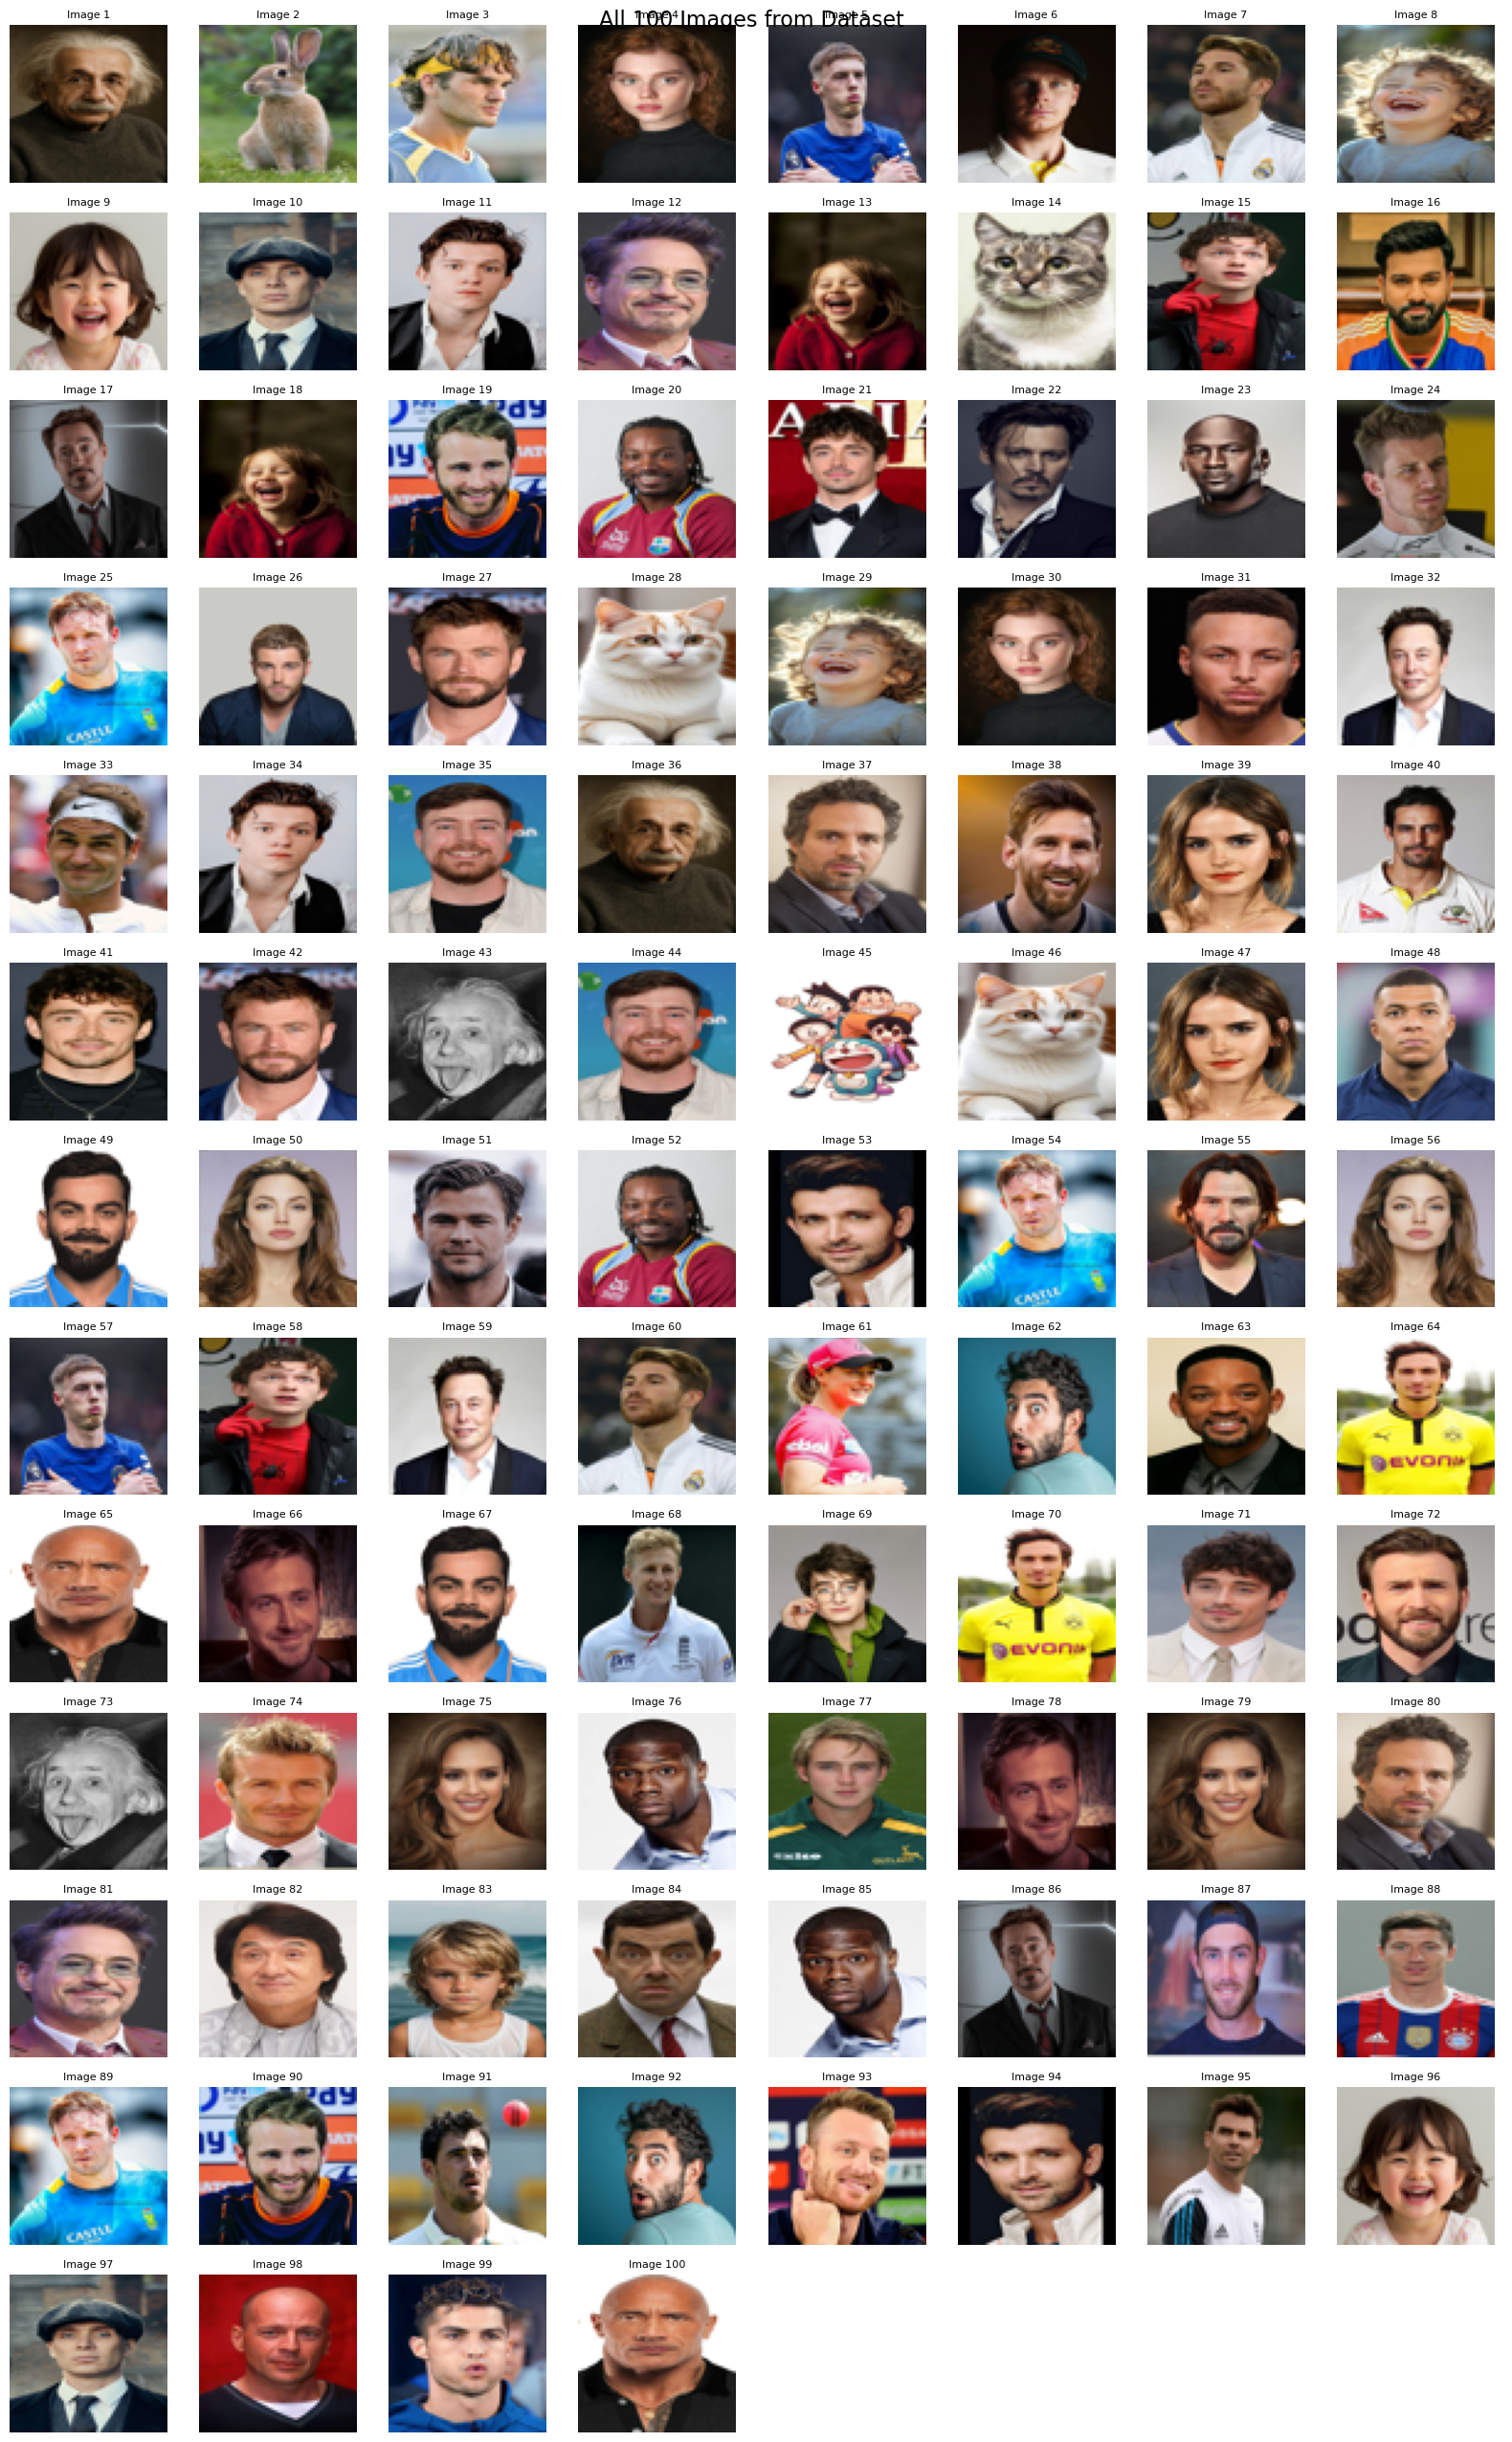

In [150]:
# Initialize model and load data
pca_model = PCAImageReconstruction(n_components=N_COMPONENTS, image_size=IMAGE_SIZE)

# Load images
images = pca_model.load_images(DATASET_FOLDER)
print(f"Dataset shape: {images.shape}")
print(f"Memory usage: {images.nbytes / (1024**2):.1f} MB")

# Display all images from dataset
n_images = len(images)
n_cols = 8  # Number of columns in display grid
n_rows = (n_images + n_cols - 1) // n_cols  # Calculate required rows

print(f"Displaying all {n_images} images from dataset")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))

# Handle single row case
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Display all images
for i in range(n_images):
    row, col = i // n_cols, i % n_cols
    axes[row, col].imshow(images[i])
    axes[row, col].set_title(f'Image {i+1}', fontsize=8)
    axes[row, col].axis('off')

# Hide unused subplot spaces
for i in range(n_images, n_rows * n_cols):
    row, col = i // n_cols, i % n_cols
    axes[row, col].axis('off')

plt.suptitle(f'All {n_images} Images from Dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [151]:
# Fit PCA model
transformed_data = pca_model.fit_transform()

# Analysis metrics
original_dim = pca_model.flattened_images.shape[1]
reduced_dim = transformed_data.shape[1]
compression_ratio = original_dim / reduced_dim

print(f"\n=== PCA Analysis Results ===")
print(f"Original dimensions: {original_dim:,}")
print(f"Reduced dimensions: {reduced_dim}")
print(f"Compression ratio: {compression_ratio:.1f}:1")
print(f"Space reduction: {(1-reduced_dim/original_dim)*100:.1f}%")

# Variance analysis
explained_variance = pca_model.pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find components for variance thresholds
comp_90 = np.argmax(cumulative_variance >= 0.9) + 1
comp_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Components for 90% variance: {comp_90}")
print(f"Components for 95% variance: {comp_95}")

PCA fitted: 97.1% variance explained

=== PCA Analysis Results ===
Original dimensions: 12,288
Reduced dimensions: 50
Compression ratio: 245.8:1
Space reduction: 99.6%
Components for 90% variance: 30
Components for 95% variance: 43


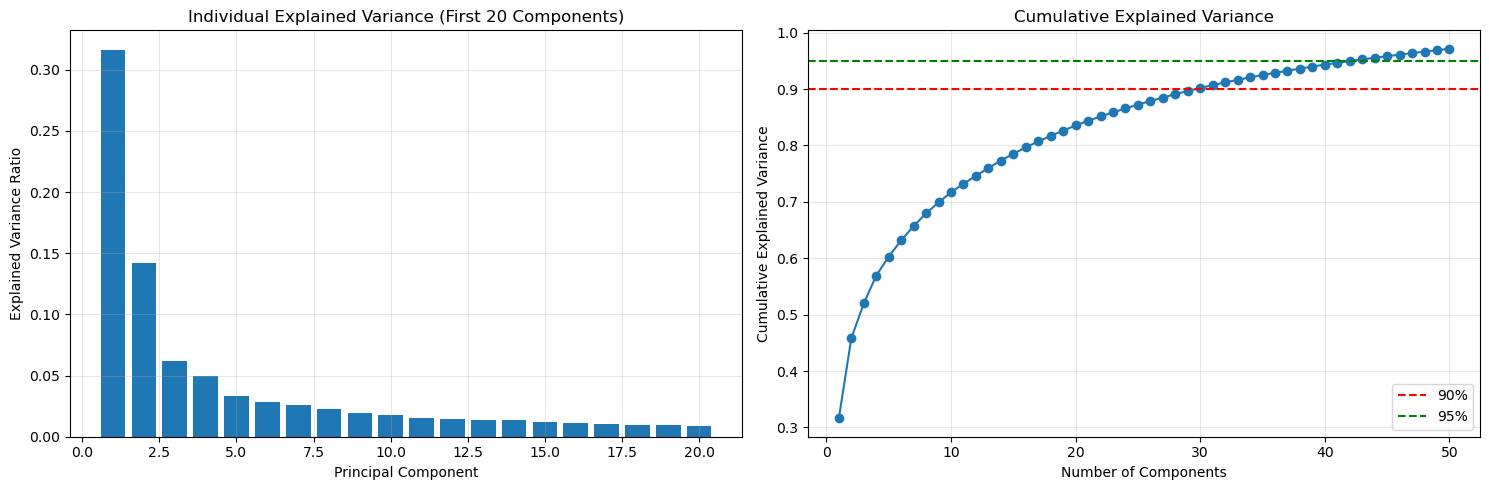

In [152]:
# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Individual variance
ax1.bar(range(1, 21), explained_variance[:20])
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Individual Explained Variance (First 20 Components)')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-')
ax2.axhline(y=0.90, color='r', linestyle='--', label='90%')
ax2.axhline(y=0.95, color='g', linestyle='--', label='95%')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Showing reconstruction comparison for 5 randomly selected images


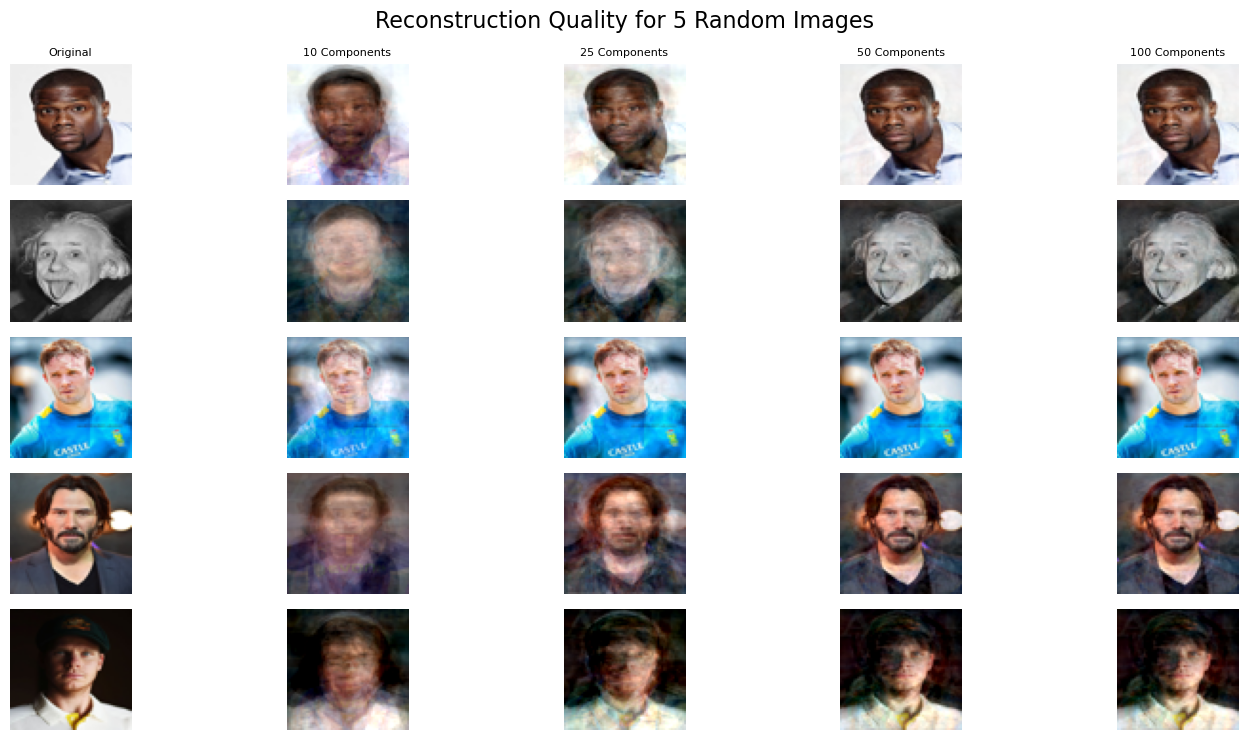

In [160]:
# Compare reconstructions
component_counts = [10, 25, 50, 100]
n_total_images = len(pca_model.original_images)
n_select = min(5, n_total_images)  # Select up to 5 images

# Randomly select indices
selected_indices = np.random.choice(n_total_images, n_select, replace=False)

print(f"Showing reconstruction comparison for {n_select} randomly selected images")

fig_height = max(3, n_select * 1.5)
fig, axes = plt.subplots(n_select, len(component_counts) + 1, figsize=(15, fig_height))

if n_select == 1:
    axes = axes.reshape(1, -1)

for idx, i in enumerate(selected_indices):
    axes[idx, 0].imshow(pca_model.original_images[i])
    axes[idx, 0].set_title('Original' if idx == 0 else '', fontsize=8)
    axes[idx, 0].set_ylabel(f'Image {i+1}', rotation=0, labelpad=20, fontsize=8)
    axes[idx, 0].axis('off')
    
    for j, n_comp in enumerate(component_counts):
        reconstructed = pca_model.reconstruct(n_comp)
        axes[idx, j + 1].imshow(reconstructed[i])
        if idx == 0:
            axes[idx, j + 1].set_title(f'{n_comp} Components', fontsize=8)
        axes[idx, j + 1].axis('off')

plt.suptitle(f'Reconstruction Quality for {n_select} Random Images', fontsize=16)
plt.tight_layout()
plt.show()

Calculating reconstruction errors...
Components:  5 → MSE: 100.67
Components: 10 → MSE: 97.98
Components: 15 → MSE: 94.14
Components: 20 → MSE: 90.18
Components: 25 → MSE: 85.46
Components: 30 → MSE: 80.04
Components: 40 → MSE: 66.56
Components: 50 → MSE: 48.72


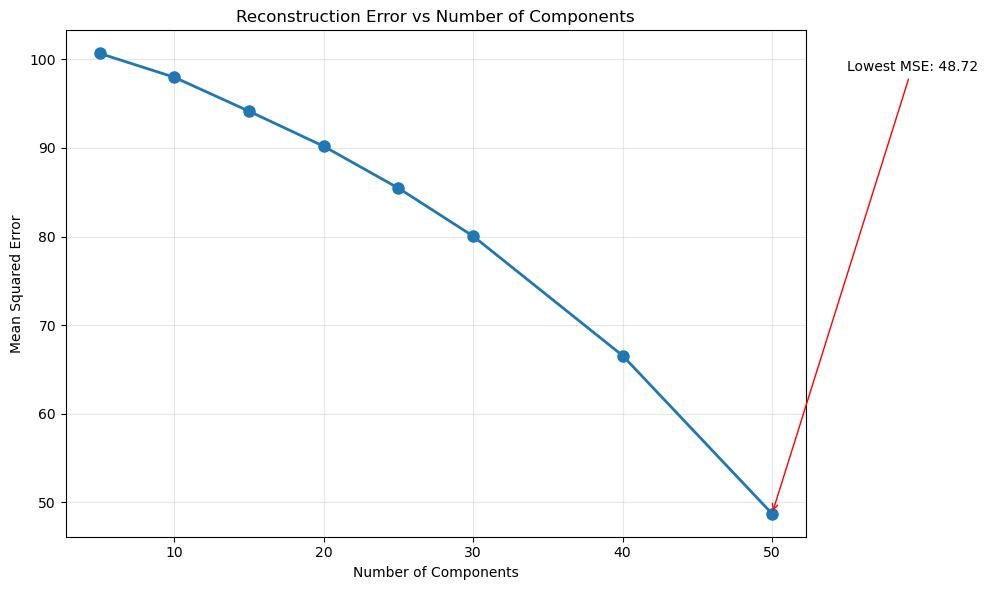

In [154]:
# Calculate reconstruction errors
test_components = [5, 10, 15, 20, 25, 30, 40, 50]
mse_errors = []

print("Calculating reconstruction errors...")
for n_comp in test_components:
    reconstructed = pca_model.reconstruct(n_comp)
    mse = np.mean((pca_model.original_images - reconstructed) ** 2)
    mse_errors.append(mse)
    print(f"Components: {n_comp:2d} → MSE: {mse:.2f}")

# Plot error analysis
plt.figure(figsize=(10, 6))
plt.plot(test_components, mse_errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')
plt.title('Reconstruction Error vs Number of Components')
plt.grid(True, alpha=0.3)

# Highlight optimal point
min_idx = np.argmin(mse_errors)
plt.annotate(f'Lowest MSE: {mse_errors[min_idx]:.2f}',
             xy=(test_components[min_idx], mse_errors[min_idx]),
             xytext=(test_components[min_idx] + 5, mse_errors[min_idx] + 50),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

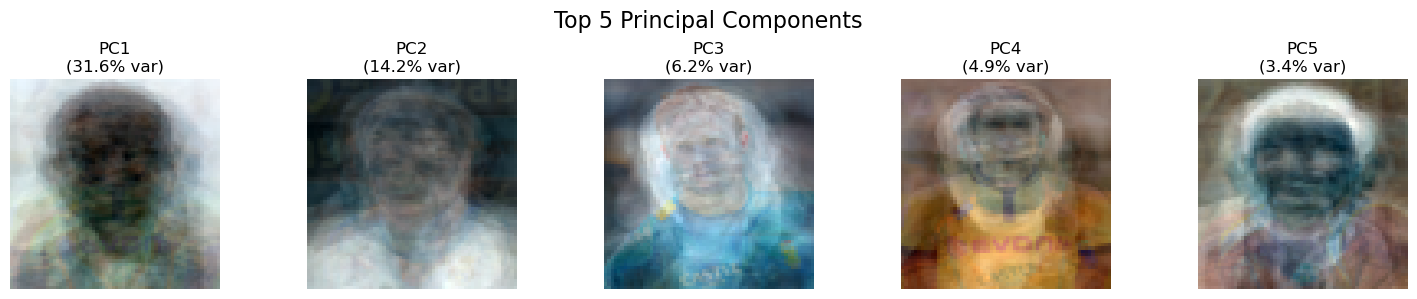

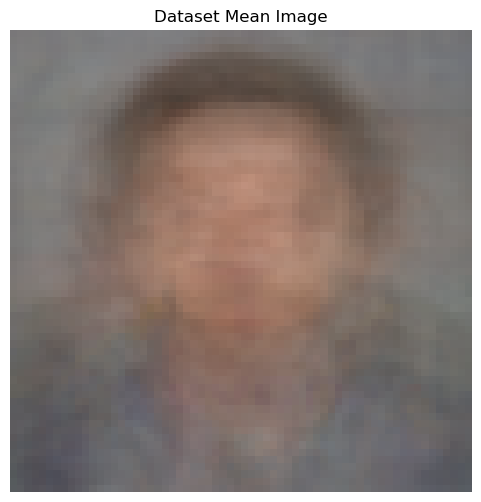

In [155]:
# Visualize top principal components
n_show = 5
fig, axes = plt.subplots(1, n_show, figsize=(15, 3))

for i in range(n_show):
    # Reshape component to image format
    component = pca_model.pca.components_[i]
    comp_img = component.reshape(*IMAGE_SIZE, 3)
    
    # Normalize for visualization
    comp_img = (comp_img - comp_img.min()) / (comp_img.max() - comp_img.min())
    
    axes[i].imshow(comp_img)
    axes[i].set_title(f'PC{i+1}\n({explained_variance[i]:.1%} var)')
    axes[i].axis('off')

plt.suptitle('Top 5 Principal Components', fontsize=16)
plt.tight_layout()
plt.show()

# Show mean image
mean_img = pca_model.pca.mean_.reshape(*IMAGE_SIZE, 3)
mean_img = (mean_img * 255).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(mean_img)
plt.title('Dataset Mean Image')
plt.axis('off')
plt.show()

In [156]:
# Calculate final metrics
final_reconstruction = pca_model.reconstruct()
final_mse = np.mean((pca_model.original_images - final_reconstruction) ** 2)

# Storage analysis
original_size = pca_model.original_images.nbytes
compressed_size = (pca_model.transformed_data.nbytes + 
                  pca_model.pca.components_.nbytes + 
                  pca_model.pca.mean_.nbytes)

print("="*50)
print("         PCA IMAGE RECONSTRUCTION RESULTS")
print("="*50)
print(f"Dataset Information:")
print(f"  • Images processed: {len(pca_model.original_images)}")
print(f"  • Image dimensions: {IMAGE_SIZE[0]}×{IMAGE_SIZE[1]}")
print(f"  • Original size: {original_size/(1024**2):.1f} MB")

print(f"\nPCA Configuration:")
print(f"  • Components used: {N_COMPONENTS}")
print(f"  • Variance explained: {cumulative_variance[N_COMPONENTS-1]:.1%}")
print(f"  • Compression ratio: {compression_ratio:.1f}:1")

print(f"\nReconstruction Quality:")
print(f"  • Final MSE: {final_mse:.2f}")
print(f"  • Storage reduction: {(1-compressed_size/original_size)*100:.1f}%")

print(f"\nKey Points:")
print(f"  • First component explains {explained_variance[0]:.1%} of variance")
print(f"  • {comp_90} components needed for 90% variance")
print(f"  • {comp_95} components needed for 95% variance")
print("="*50)

         PCA IMAGE RECONSTRUCTION RESULTS
Dataset Information:
  • Images processed: 100
  • Image dimensions: 64×64
  • Original size: 1.2 MB

PCA Configuration:
  • Components used: 50
  • Variance explained: 97.1%
  • Compression ratio: 245.8:1

Reconstruction Quality:
  • Final MSE: 48.72
  • Storage reduction: -311.3%

Key Points:
  • First component explains 31.6% of variance
  • 30 components needed for 90% variance
  • 43 components needed for 95% variance
